In [1]:
import sys
import os
import numpy as np
import pandas as pd

# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping

Download datasets

In [2]:
dataset_PT = TSD(file_path='../datasets/power_transitions.xlsx')
dataset_100y = TSD(categories=['sc'], file_path="../datasets/100_yr_dataset.csv")

Dataset loaded from ../datasets/power_transitions.xlsx
Dataset loaded from ../datasets/100_yr_dataset.xlsx


impute MSP

In [5]:
religion_df = download_data("https://seshat-db.com/api/rt/official-religions/")
religion_df.reset_index(drop=True, inplace=True)

religions = dataset_PT.raw['PolityName'].apply(lambda x: religion_df.loc[religion_df.polity_new_name == x, "coded_value_religion_name"].iloc[0] if x in religion_df.polity_new_name.values else np.nan)
dataset_PT.raw['religion'] = religions
dataset_PT.scv['religion'] = religions

dataset_PT.scv_imputed['MSP'] = dataset_PT.scv['MSP']
for index,row in dataset_PT.scv.iterrows():
    if pd.isna(row['MSP']):
        if pd.isna(row['religion']):
            continue
        msp_inferred = (dataset_PT.scv.loc[(dataset_PT.scv.religion == row['religion'])&(dataset_PT.scv.MSP.notna()), 'MSP'])
        msp_inferred = msp_inferred.dropna()
        
        if len(msp_inferred) > 0:
            dataset_PT.scv_imputed.loc[index, 'MSP'] = msp_inferred.mean()

religions = dataset_100y.raw['PolityName'].apply(lambda x: religion_df.loc[religion_df.polity_new_name == x, "coded_value_religion_name"].iloc[0] if x in religion_df.polity_new_name.values else np.nan)
dataset_100y.raw['religion'] = religions
dataset_100y.scv['religion'] = religions

dataset_100y.scv_imputed['MSP'] = dataset_100y.scv['MSP']
for index,row in dataset_100y.scv.iterrows():
    if pd.isna(row['MSP']):
        if pd.isna(row['religion']):
            continue
        msp_inferred = (dataset_100y.scv.loc[(dataset_100y.scv.religion == row['religion'])&(dataset_100y.scv.MSP.notna()), 'MSP'])
        msp_inferred = msp_inferred.dropna()
        
        if len(msp_inferred) > 0:
            dataset_100y.scv_imputed.loc[index, 'MSP'] = msp_inferred.mean()

Downloaded 441 rows


Add crisis variables

In [6]:
crisis_vars = ['overturn'
              ,'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
            #   ,'external_invasion'
            #   ,'external_interference'
              ]
PT_mapping = {'PT_types':{}}
for col in crisis_vars:
    PT_mapping['PT_types'][col] = 1

dataset_PT.scv['Crisis'] = dataset_PT.raw.apply(lambda row: weighted_mean(row, PT_mapping, "PT_types", imputation='remove'), axis=1)
dataset_PT.scv_imputed['Crisis'] = dataset_PT.scv['Crisis']

Check for missing data

In [7]:
scale_cols = ['Pop','Terr','Cap','Hierarchy']
non_scale_cols = ['Government', 'Infrastructure', 'Information', 'Money']
print(f"Missing rows in PT, total number of rows {len(dataset_PT.scv)}")
print('Missing rows in scale columns')
print(dataset_PT.scv_imputed[scale_cols].isna().any(axis=1).sum())
print("Missing rows in non-scale columns")
print(dataset_PT.scv_imputed[non_scale_cols].isna().any(axis=1).sum())
print("Missing rows in MSP")
print(dataset_PT.scv_imputed[['MSP']].isna().any(axis=1).sum())
print("Total not complete rows")
print(dataset_PT.scv_imputed[scale_cols+non_scale_cols+['MSP']].isna().any(axis=1).sum())

Missing rows in PT, total number of rows 3133
Missing rows in scale columns
1065
Missing rows in non-scale columns
387
Missing rows in MSP
1217
Total not complete rows
1625


Compute scale and non-scale PCA

In [8]:
scale_cols = ['Pop','Terr','Cap','Hierarchy']
scale_pca = dataset_100y.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols))
dataset_PT.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols), pca_func = scale_pca, contributions=True)

Explained variance by each PC:
PC1: 85.56%
PC2: 7.09%
PC3: 5.11%
PC4: 2.23%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 85.56%
PC2: 7.09%
PC3: 5.11%
PC4: 2.23%
PC1 contributions:
Pop: 0.52
Terr: 0.50
Cap: 0.50
Hierarchy: 0.49


PCA(n_components=4)

In [9]:
inst_cols = ['Government', 'Infrastructure', 'Information', 'Money', 'MSP']
inst_pca = dataset_100y.compute_PCA(cols = inst_cols, col_name = 'Inst', n_cols = 1, n_PCA= len(inst_cols))
dataset_PT.compute_PCA(cols = inst_cols, col_name = 'Inst', n_cols = 1, n_PCA= len(inst_cols), pca_func = inst_pca, contributions=True)

there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 72.80%
PC2: 13.41%
PC3: 6.52%
PC4: 4.47%
PC5: 2.80%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 72.80%
PC2: 13.41%
PC3: 6.52%
PC4: 4.47%
PC5: 2.80%
PC1 contributions:
Government: 0.48
Infrastructure: 0.46
Information: 0.49
Money: 0.45
MSP: 0.33


PCA(n_components=5)

In [10]:
dataset_PT.scv_imputed

NGA  PolityID     PolityName  Year       Pop  \
0     Middle Yellow River Valley         1  cn_qing_dyn_1  1661  8.140739   
1     Middle Yellow River Valley         1  cn_qing_dyn_1  1722  8.140739   
2     Middle Yellow River Valley         1  cn_qing_dyn_1  1735  8.140739   
3     Middle Yellow River Valley         1  cn_qing_dyn_1  1796  8.140739   
4     Middle Yellow River Valley         2  cn_qing_dyn_2  1820  8.469822   
...                          ...       ...            ...   ...       ...   
3128                         NaN       811   hu_later_dyn  1458       NaN   
3129                         NaN       811   hu_later_dyn  1490       NaN   
3130                         NaN       811   hu_later_dyn  1516       NaN   
3131                         NaN       811   hu_later_dyn  1526       NaN   
3132                         NaN       818  no_norway_k_1  1257       NaN   

          Terr       Cap  Hierarchy  Government  Infrastructure  Information  \
0     7.117271  5.835828   6.750000    0.727273             1.0     0.933333   
1     7.117271  5.835828   6.750000    0.727273             1.0     0.933333   
2     7.117271  5.835828   6.750000    0.727273             1.0     0.933333   
3     7.117271  5.835828   6.750000    0.727273             1.0     0.933333   
4     7.053078  5.949825   6.773585    0.909091             1.0     0.866667   
...        ...       ...        ...         ...             ...          ...   
3128       NaN       NaN        NaN         NaN             NaN          NaN   
3129       NaN       NaN        NaN         NaN             NaN          NaN   
3130       NaN       NaN        NaN         NaN             NaN          NaN   
3131       NaN       NaN        NaN         NaN             NaN          NaN   
3132       NaN       NaN        NaN         NaN             NaN          NaN   

      Money dataset  MSP    Crisis   Scale_1    Inst_1  
0       6.0      PT  0.9  0.000000  2.593281  2.100881  
1       6.0      PT  0.9  0.000000  2.593281  2.100881  
2       6.0      PT  0.9  0.000000  2.593281  2.100881  
3       6.0      PT  0.9  0.166667  2.593281  2.100881  
4       6.0      PT  0.9  0.000000  2.836403  2.292009  
...     ...     ...  ...       ...       ...       ...  
3128    NaN      PT  NaN  0.166667       NaN       NaN  
3129    NaN      PT  NaN  0.166667       NaN       NaN  
3130    NaN      PT  NaN  0.000000       NaN       NaN  
3131    NaN      PT  NaN  0.333333       NaN       NaN  
3132    NaN      PT  NaN  0.166667       NaN       NaN  

[3133 rows x 17 columns]

In [11]:
dataset_PT.save_dataset('../datasets', 'PT_dataset_imputed')

Dataset saved to ../datasets/PT_dataset_imputed.xlsx


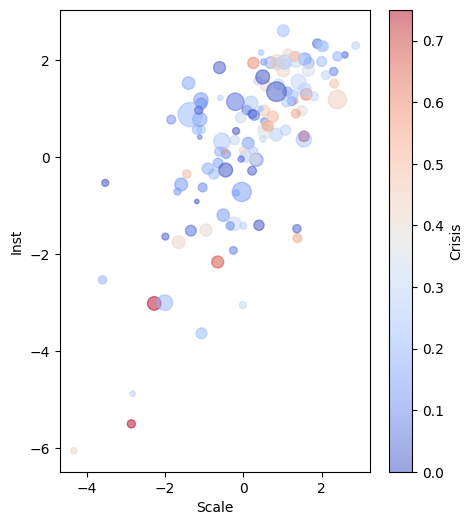

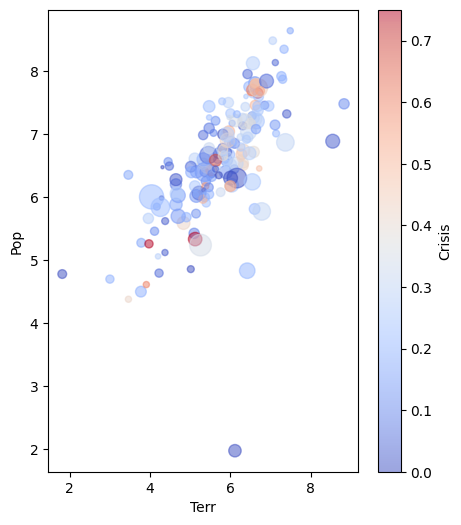

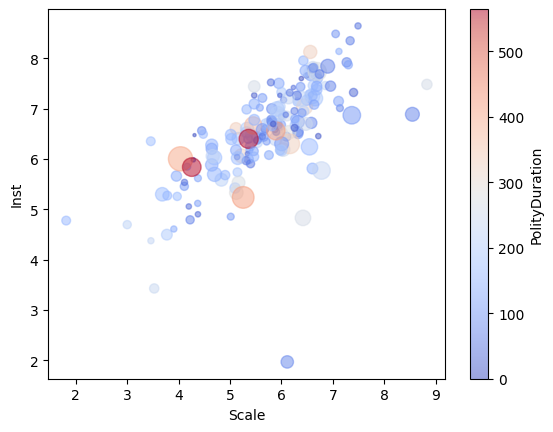

In [12]:
import matplotlib.pyplot as plt

polity_group = dataset_PT.scv_imputed.groupby('PolityName')
fig, ax = plt.subplots(figsize=(5, 6))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Inst_1'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['Crisis'].mean()
pol_duration = polity_group['Year'].max() - polity_group['Year'].min()
num_observations = polity_group.size()
v_max = mean_crisis.max()*.75
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 5,
                      alpha=0.5,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')

# Show the plot
plt.ylabel('Inst')
plt.xlabel('Scale')
plt.show()

fig, ax = plt.subplots(figsize=(5, 6))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Pop'].mean()
mean_scale_1 = polity_group['Terr'].mean()
mean_crisis = polity_group['Crisis'].mean()
pol_duration = polity_group['Year'].max() - polity_group['Year'].min()
num_observations = polity_group.size()
v_max = mean_crisis.max()*.75
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 5,
                      alpha=0.5,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')

# Show the plot
plt.ylabel('Pop')
plt.xlabel('Terr')
plt.show()

pol_duration = polity_group['Year'].max() - polity_group['Year'].min()
num_observations = polity_group.size()
v_max = pol_duration.max()*.75
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=pol_duration,
                      cmap='coolwarm',
                      s=num_observations * 5,
                      alpha=0.5,
                      edgecolors=plt.cm.coolwarm(pol_duration / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='PolityDuration')

# Show the plot
plt.ylabel('Inst')
plt.xlabel('Scale')
plt.show()

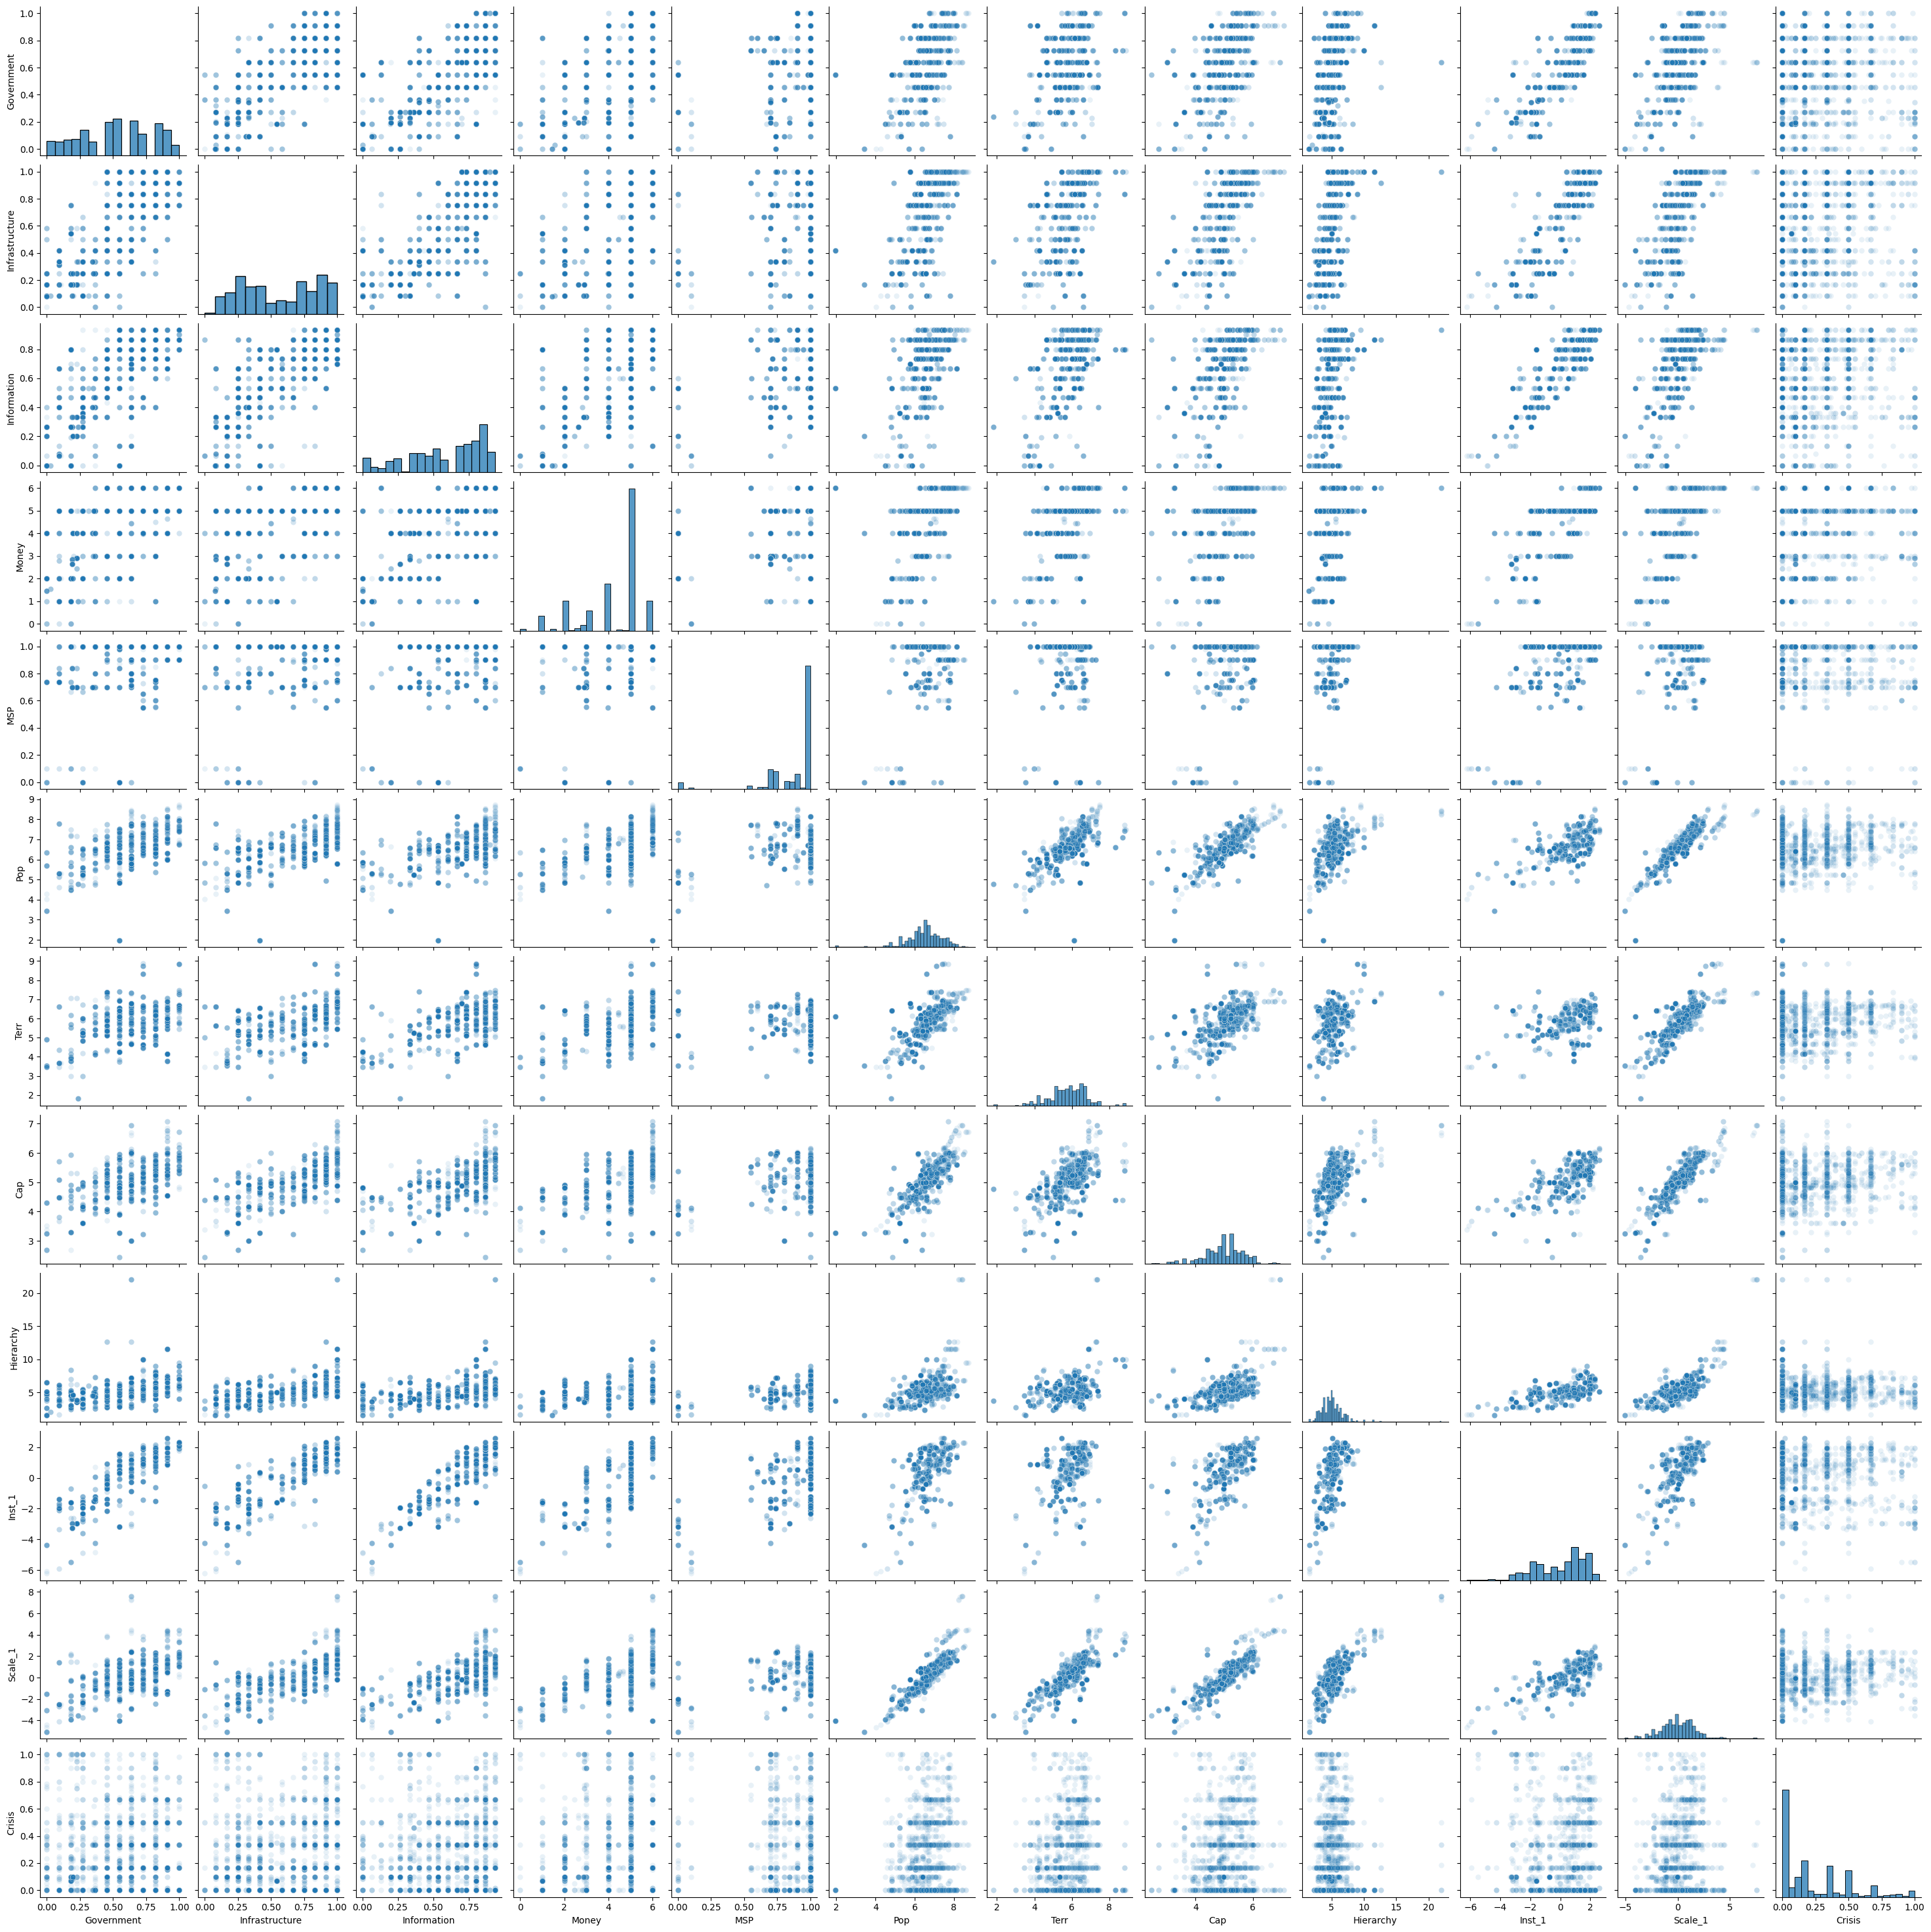

In [13]:
import seaborn as sns
sns.pairplot(dataset_PT.scv_imputed[inst_cols+scale_cols+['Inst_1', 'Scale_1', 'Crisis']], plot_kws={'alpha': 0.1})

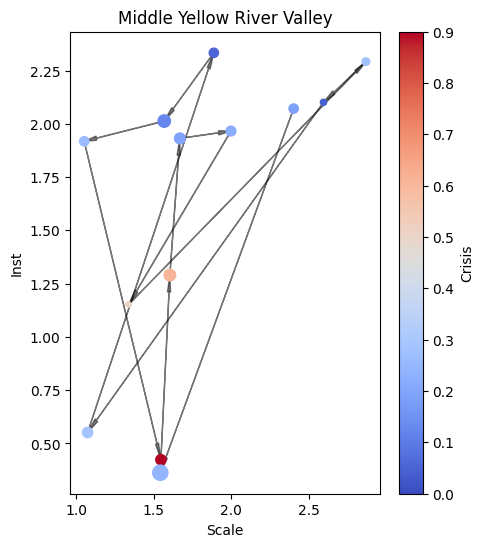

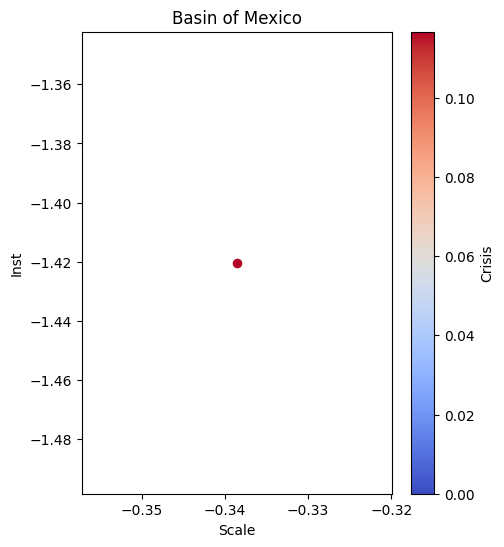

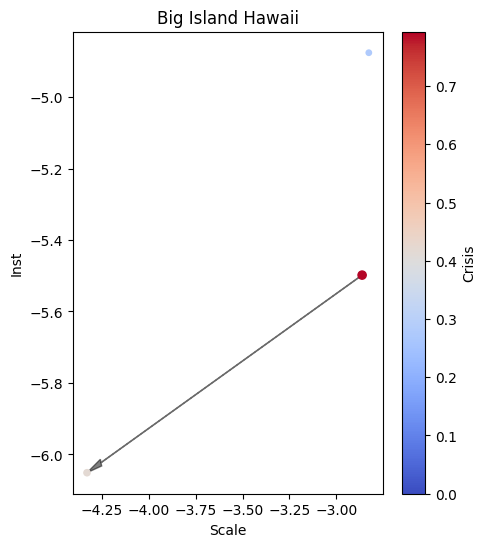

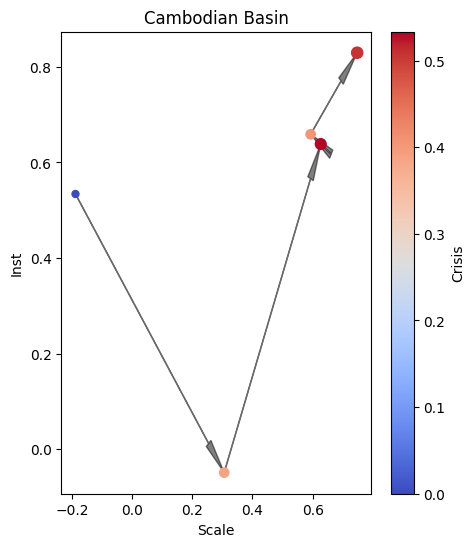

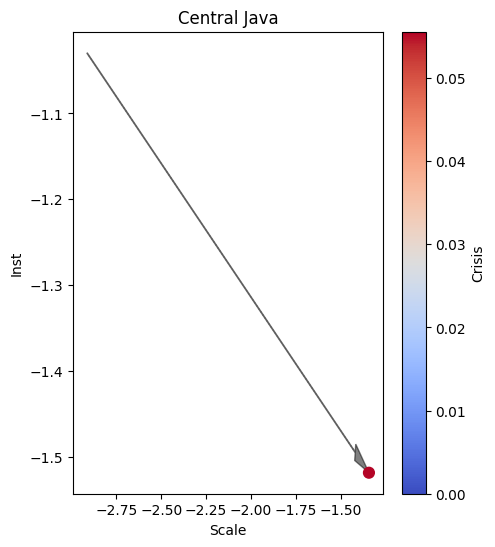

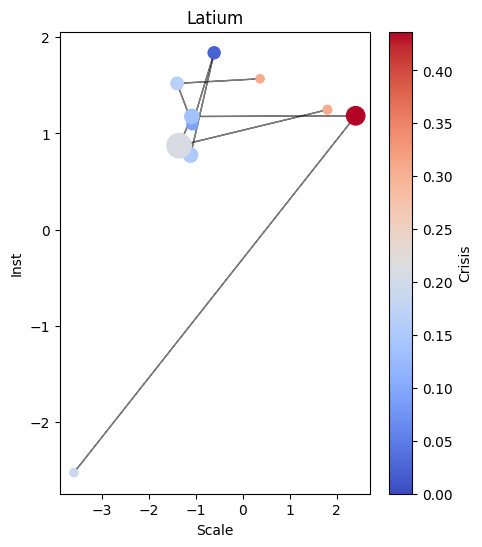

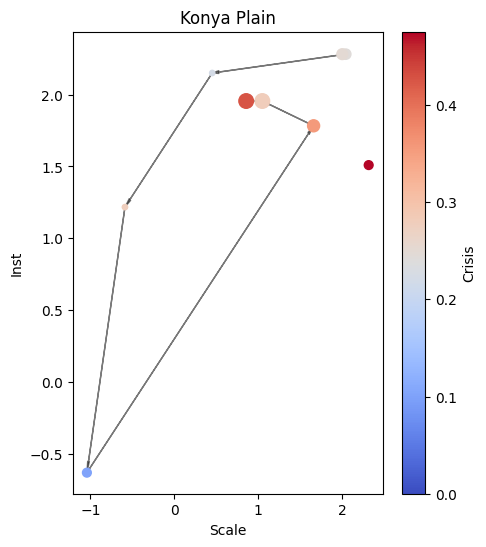

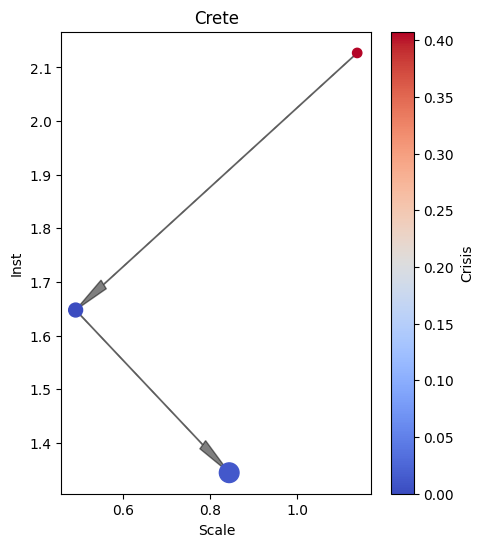

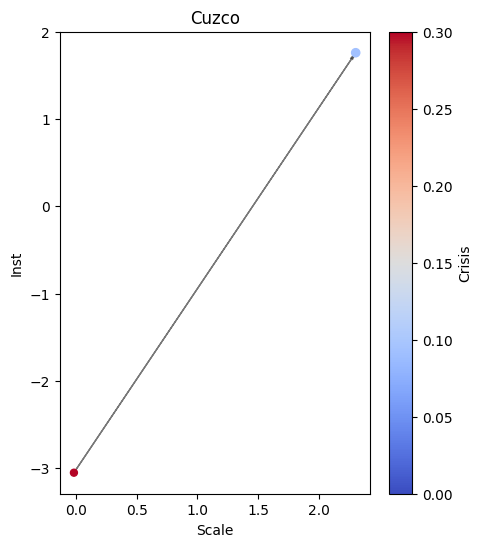

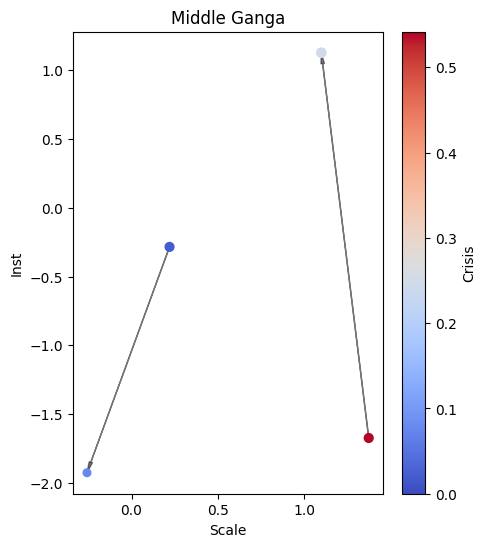

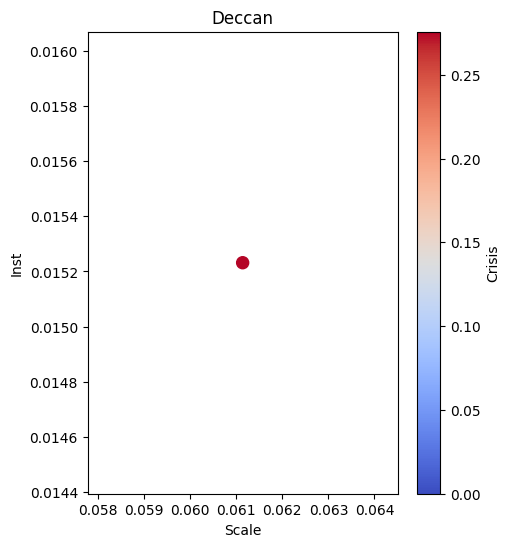

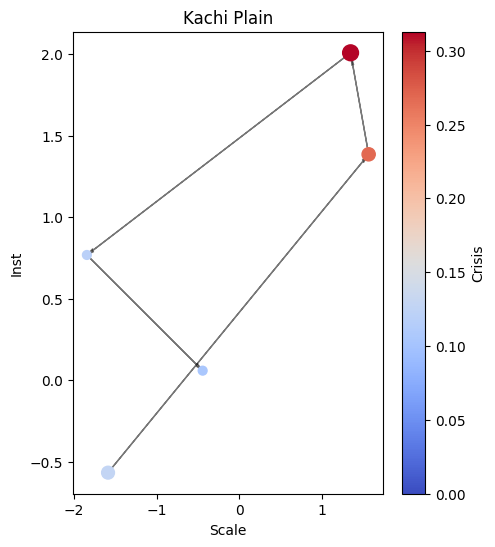

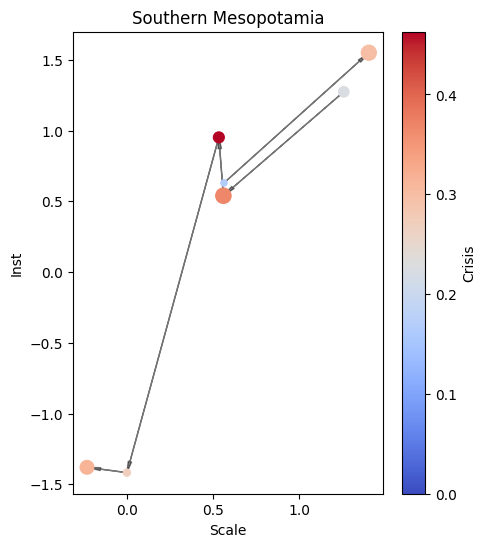

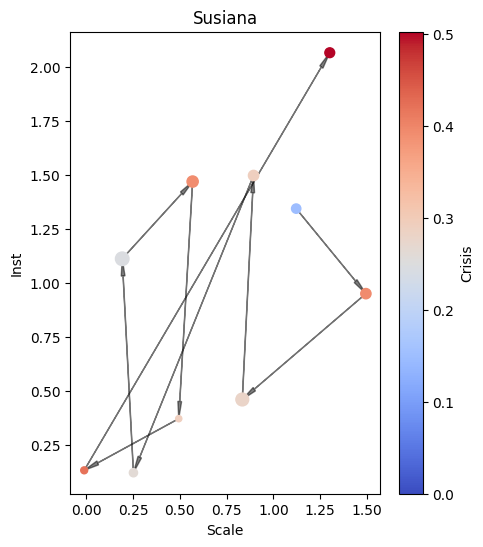

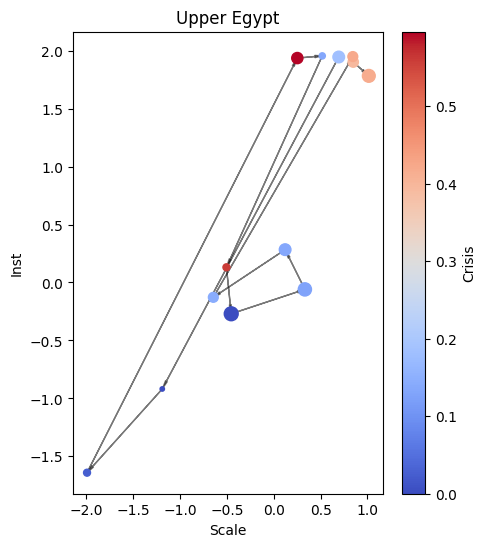

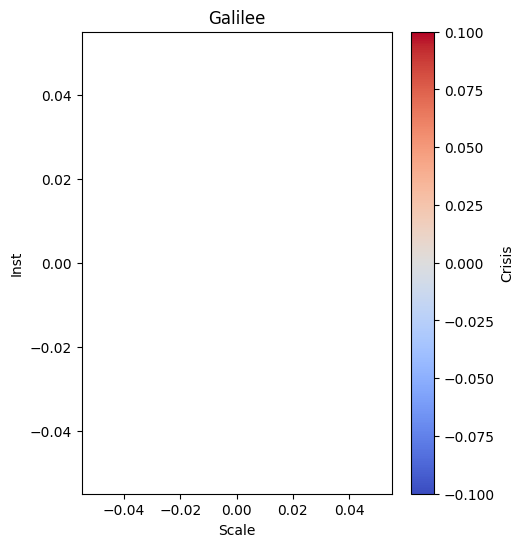

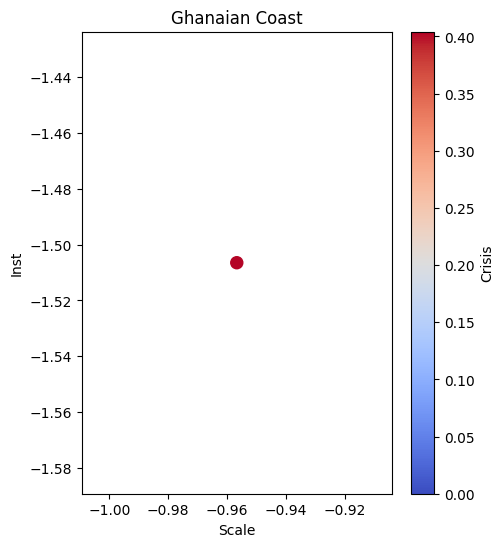

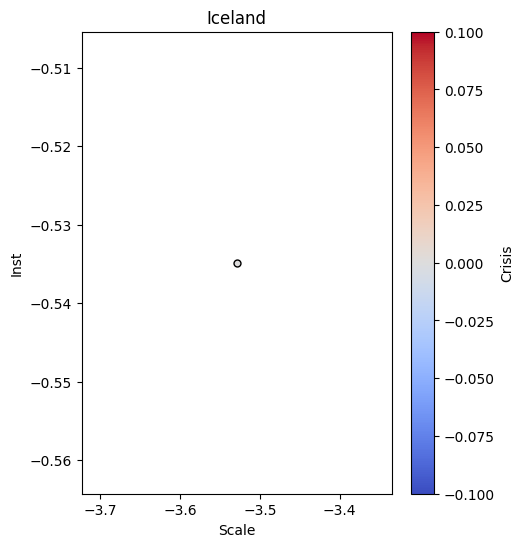

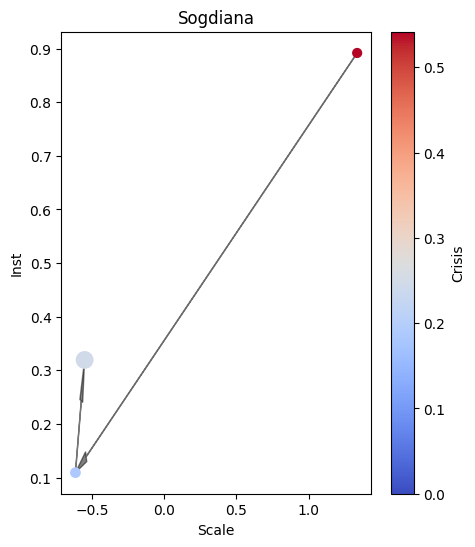

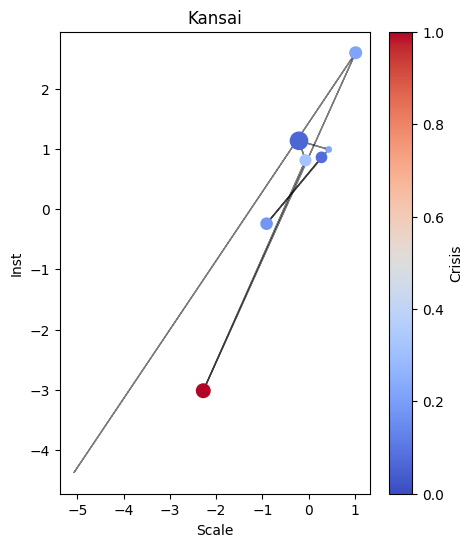

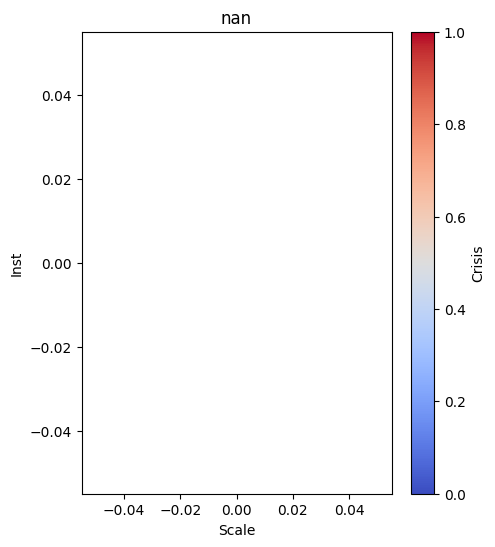

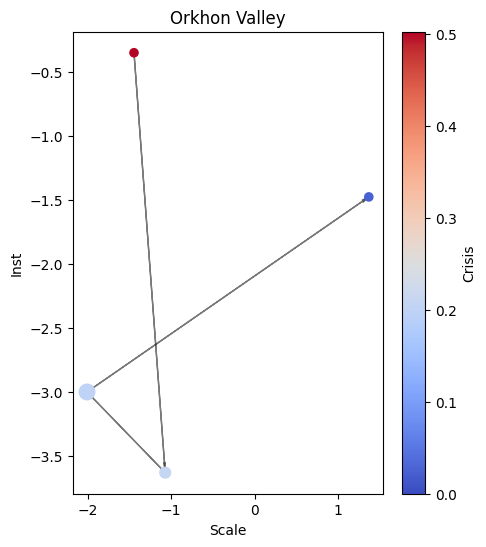

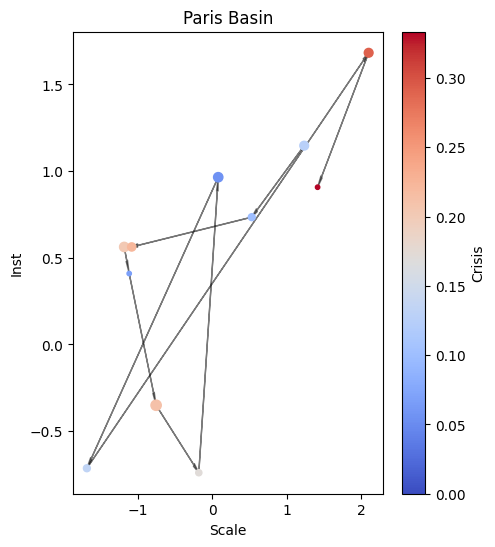

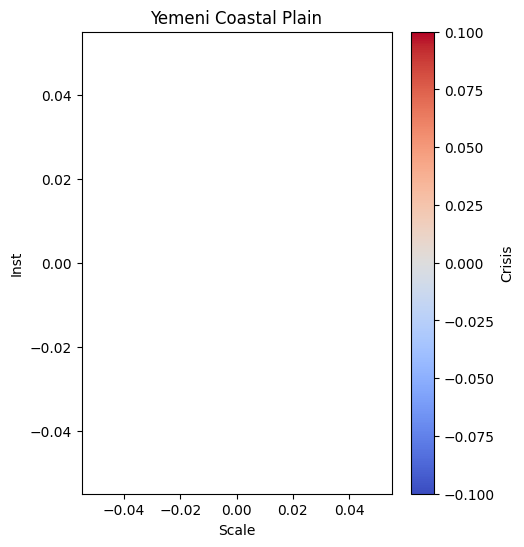

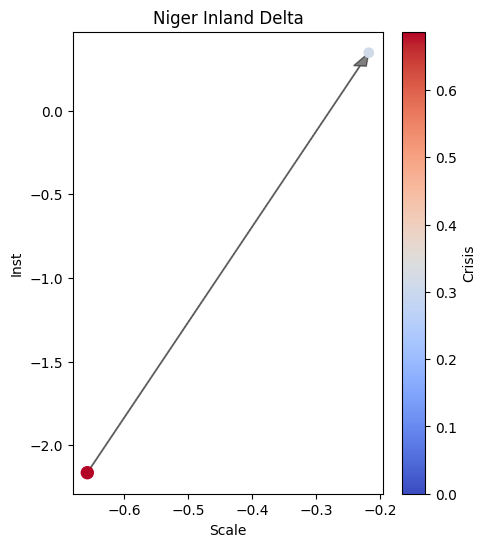

In [14]:
NGAs = dataset_PT.scv_imputed['NGA'].unique()

for nga in NGAs:
    polity_group = dataset_PT.scv_imputed.loc[dataset_PT.scv_imputed.NGA == nga].groupby('PolityName')
    fig, ax = plt.subplots(figsize=(5, 6))
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Inst_1'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    mean_crisis = polity_group['Crisis'].mean()
    num_observations = polity_group.size()
    
    for i in range(1,len(mean_inst_1)):
        dx = (mean_scale_1[i-1] - mean_scale_1[i]) 
        dy = (mean_inst_1[i-1] - mean_inst_1[i]) 
        plt.arrow(mean_scale_1[i], mean_inst_1[i],dx,dy, head_width=0.02, head_length=0.08, fc='k', ec='k', length_includes_head = True, alpha = 0.5)

    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        vmin = 0,
                        c=mean_crisis,
                        cmap='coolwarm',
                        s=num_observations * 5,
                        alpha=1.0,
                        edgecolors=plt.cm.coolwarm(mean_crisis / mean_crisis.max())
                        )

    # Add a color bar
    plt.colorbar(scatter, label='Crisis')


    # Show the plot
    plt.ylabel('Inst')
    plt.xlabel('Scale')
    plt.title(nga)
    plt.show()

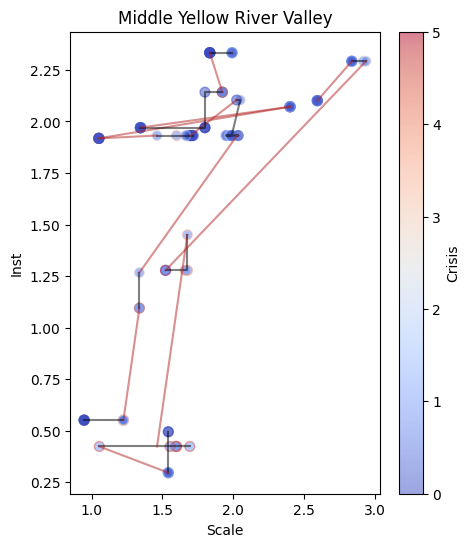

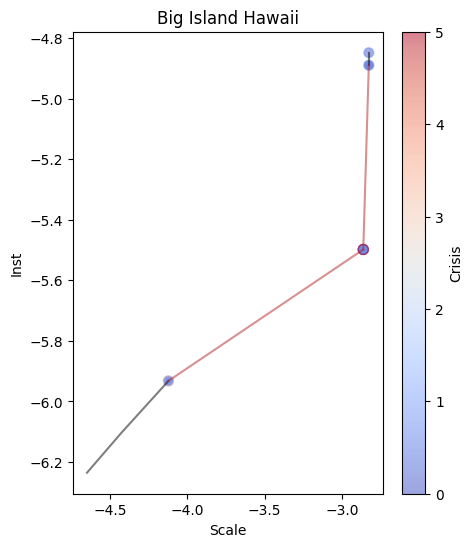

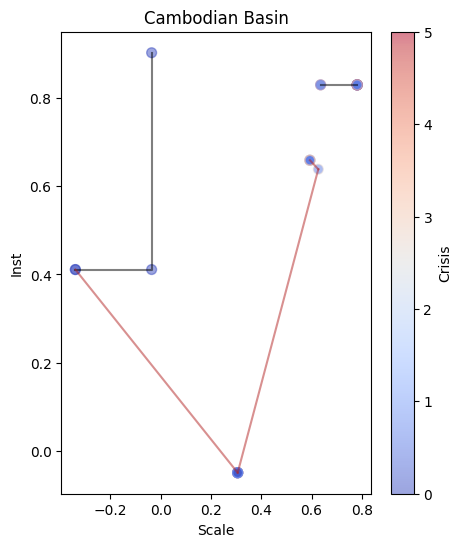

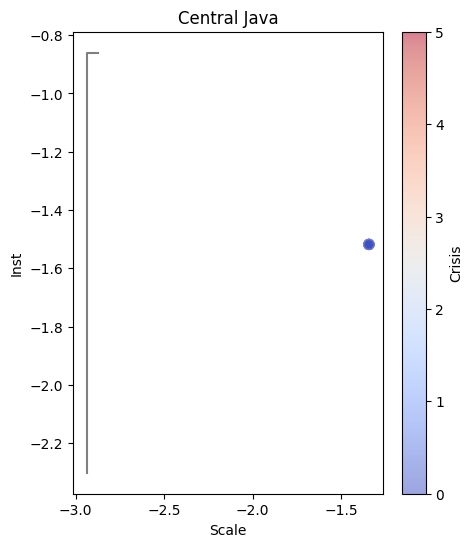

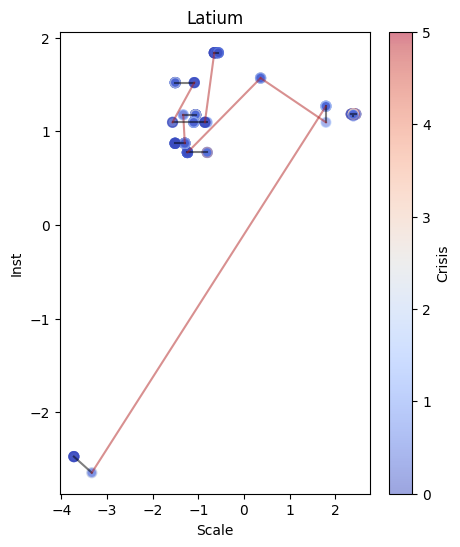

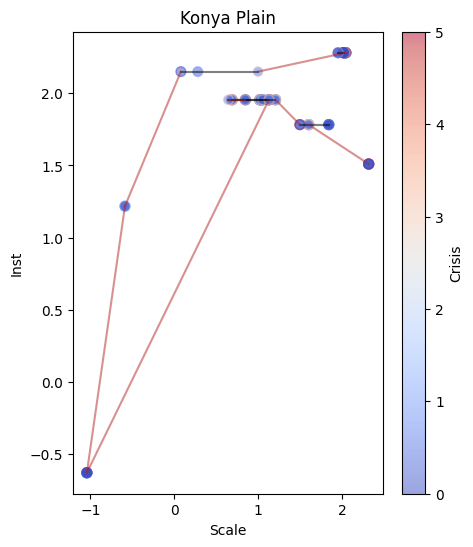

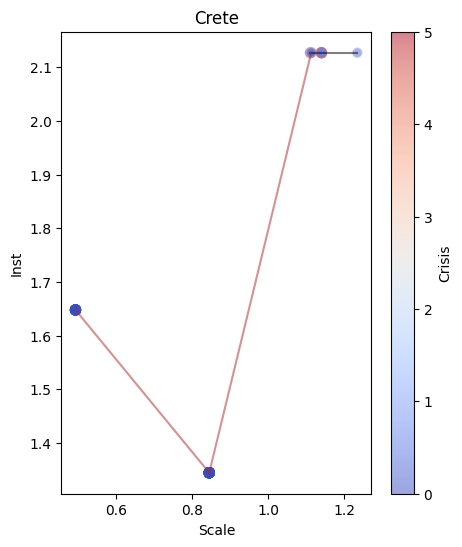

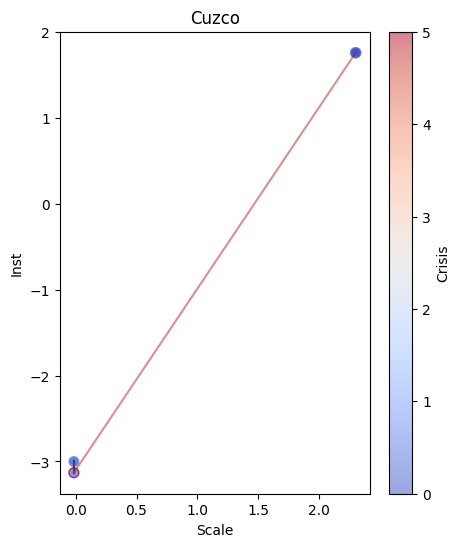

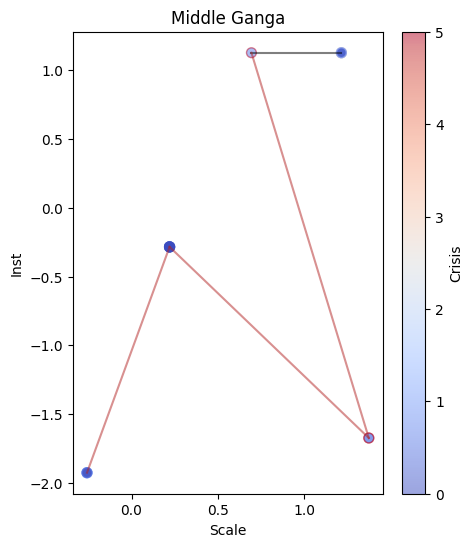

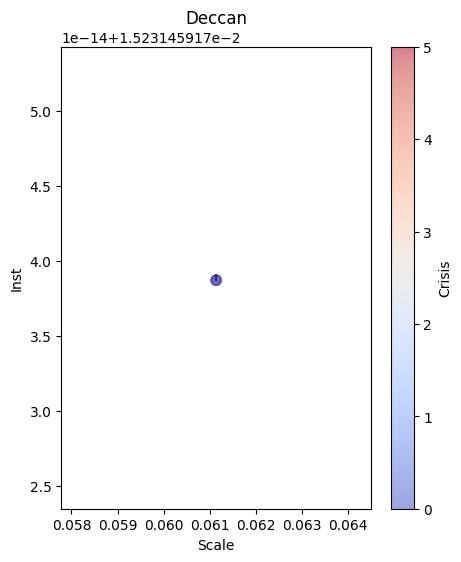

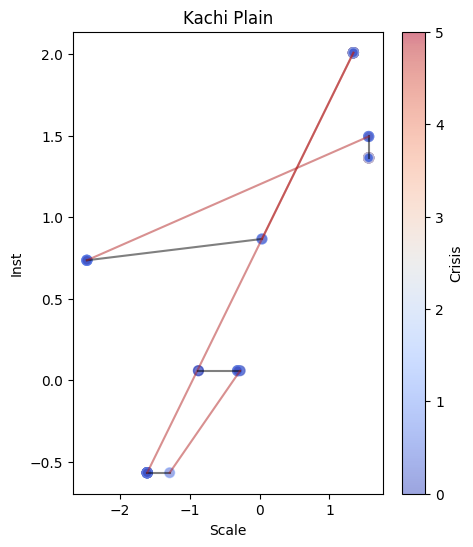

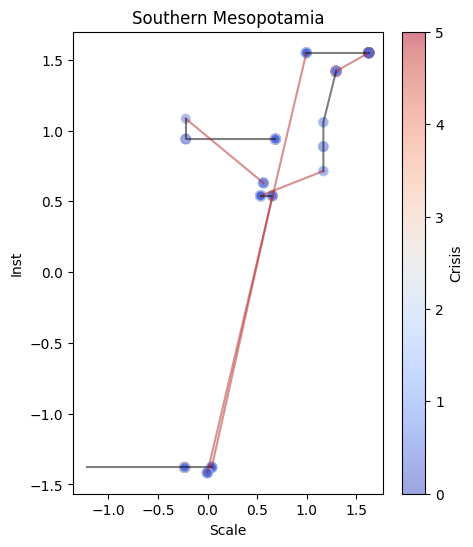

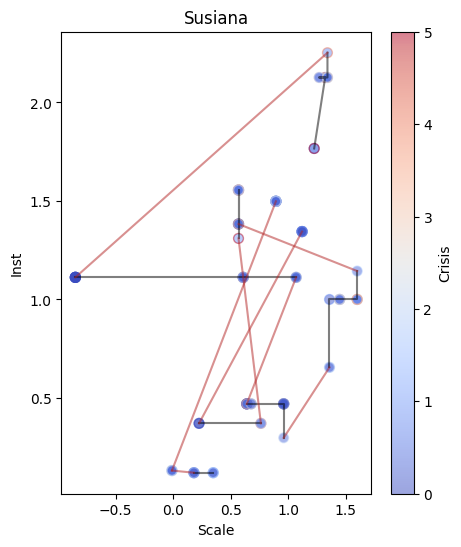

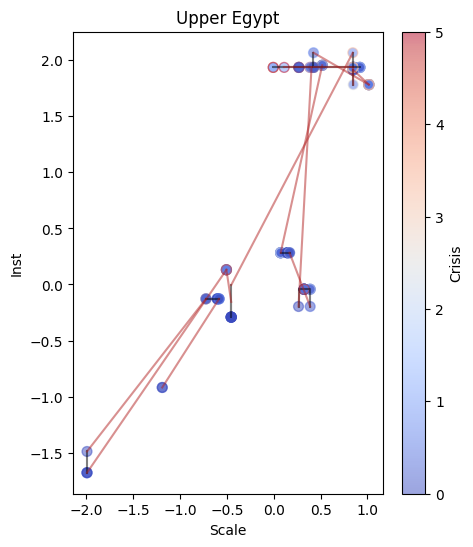

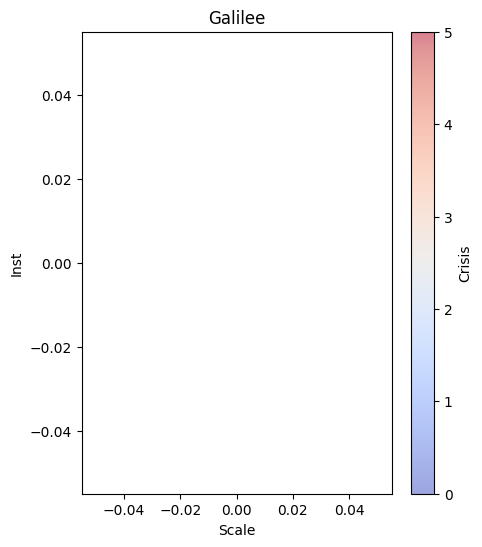

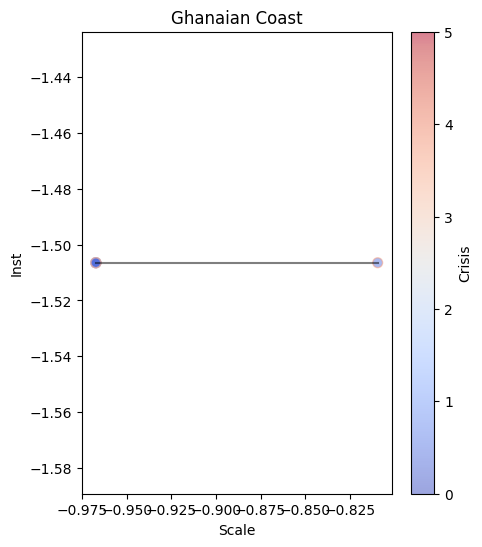

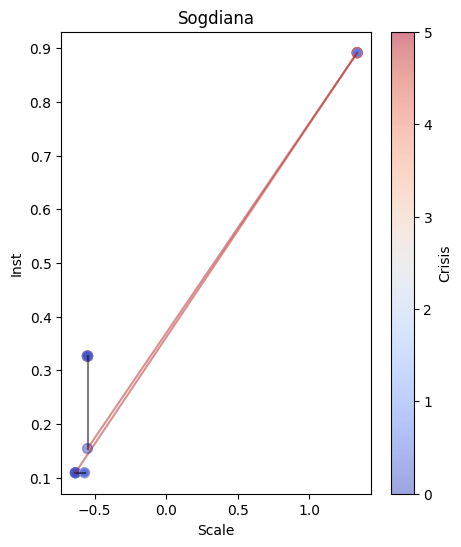

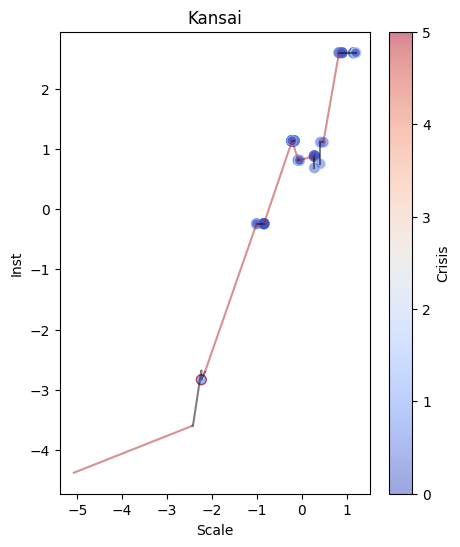

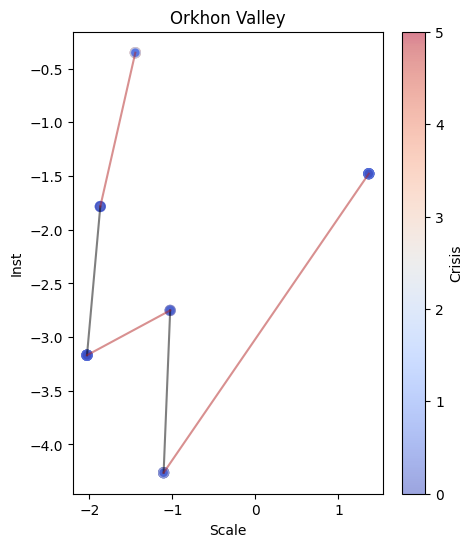

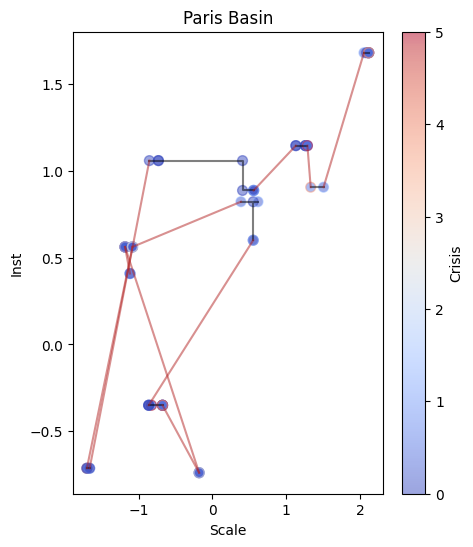

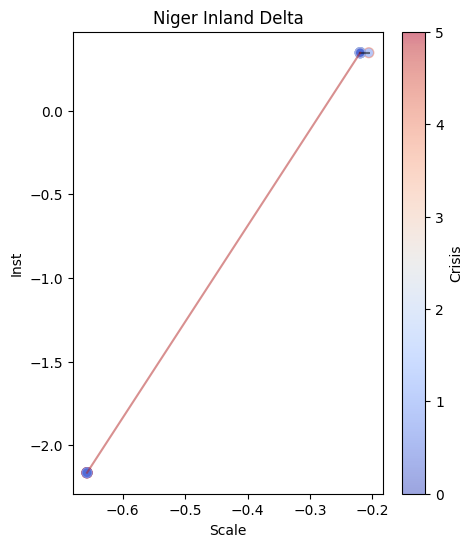

In [15]:
NGAs = dataset_PT.scv_imputed['NGA'].unique()

for nga in NGAs:

    plot_df = dataset_PT.scv_imputed[dataset_PT.scv_imputed['NGA'] == nga]
    if len(plot_df) > 10:                
        fig, ax = plt.subplots(figsize=(5, 6))

        # Create a scatter plot
        scatter = plt.scatter(plot_df['Scale_1'], plot_df['Inst_1'],
                            vmin=0,
                            vmax = 5,
                            c=plot_df['Crisis'],
                            cmap='coolwarm',
                            s=50,
                            alpha=0.5,
                            edgecolors=plt.cm.coolwarm(plot_df['Crisis'] / plot_df['Crisis'].max())
                            )
        for i,pol in enumerate(plot_df['PolityName'].unique()):
            pol_df = plot_df[plot_df['PolityName'] == pol]
            plt.plot(pol_df['Scale_1'], pol_df['Inst_1'], 'k', alpha=0.5)
            if i > 0:
                prev_pol = plot_df[plot_df['PolityName'] == plot_df['PolityName'].unique()[i-1]]
                plt.plot([prev_pol['Scale_1'].iloc[-1], pol_df['Scale_1'].iloc[0]], [prev_pol['Inst_1'].iloc[-1], pol_df['Inst_1'].iloc[0]], 'firebrick', alpha=0.5)
            
        
        # Add a color bar
        plt.colorbar(scatter, label='Crisis')         
        # Show the plot
        plt.title(nga)
        plt.ylabel('Inst')
        plt.xlabel('Scale')
        plt.show()  
    
